In [1]:
import cv2
import numpy as np
import os
from random import shuffle 
from tqdm import tqdm


In [2]:
TRAIN_DIR = "dogs_vs_cats/train/train" # Directory for train data
TEST_DIR = "dogs_vs_cats/test/test" # Directory for test data

IMG_SIZE = 50 
LR = 1e-3 # Learning Rate

MODEL_NAME = "dogs_vs_cats.{}.{}.model".format(LR, "6conv-basic-video")

In [3]:
# 2D grayscale data
# Function returns a list with 2 boolean elements that gives the value of [cat, dog] either [0, 1] or [1, 0]

def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == "cat": return [1, 0]
    elif word_label == "dog": return [0, 1] 

In [4]:
# Training data contains the labeled images

def create_train_data():
    
    training_data = []
    
    for img in tqdm(os.listdir(TRAIN_DIR)): # tqdm - loops show a smart progress meter; wrap any iterable with tqdm(iterable)
        label = label_img(img) # get the label list from the img name
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)]) # append the training data
    
    shuffle(training_data) # shuffle the training data
    np.save('train_data.npy', training_data) # Save an array to a binary file in NumPy ``.npy`` format.
    return training_data

In [5]:
# Testing data contains the unlabeled images
# img_num is the id of each image on which we have to predict the probability of the image being a dog

def process_test_data():
    
    testing_data = []
    
    for img in tqdm(os.listdir(TEST_DIR)): 
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)) # resize and read the test image
        testing_data.append([np.array(img), img_num])
    
    np.save('test_data.npy', testing_data)
    return testing_data

In [6]:
train_data = create_train_data()
# if the train data is already present
# train_data = np.load('train_data.npy')


100%|███████████████████████████████████| 25000/25000 [02:38<00:00, 158.06it/s]
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

tf.reset_default_graph() # Clears the default graph stack and resets the global default graph. Or reset the kernel 

# import tflearn.datasets.mnist as mnist 

# X, Y, test_x, test_y = mnist.load_data(one_hot=True)

# X = X.reshape([-1, 28, 28, 1])
# test_x = test_x.reshape([-1, 28, 28, 1])

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

# Change the convolution layers to 6 in the network

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax') # Possible outputs are 2 - dog or cat
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
# Changed the learning rate the 

model = tflearn.DNN(convnet, tensorboard_dir='log')

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# If model exists, load the model
if os.path.exists('{}.meta'.format(MODEL_NAME)): 
    model.load(MODEL_NAME)
    print("Model loaded")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from F:\New folder\files\Assignments\Semester 4\Miscellaneous\Anemoi Internship\Code\6 CNN\dogs_vs_cats.0.001.6conv-basic-video.model
Model loaded


In [9]:
train = train_data[:-500] # All except the last 500 of the training data
test = train_data[-500:] # Test data will be the train data from -500 onwards 
# To check if we get the same accuracy on the training data that we want on the actual testing data

In [10]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
# Feature set. i[0] in train is the image data/pixel data i[1] is the label
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME) # Run id is used to find it in tensorboard

Training Step: 5744  | total loss: 0.23828 | time: 119.164s
| Adam | epoch: 005 | loss: 0.23828 - acc: 0.9022 -- iter: 24448/24500
Training Step: 5745  | total loss: 0.23168 | time: 120.425s
| Adam | epoch: 005 | loss: 0.23168 - acc: 0.9042 | val_loss: 0.34150 - val_acc: 0.8580 -- iter: 24500/24500
--


In [12]:
model.save(MODEL_NAME) # Saving the model

INFO:tensorflow:F:\New folder\files\Assignments\Semester 4\Miscellaneous\Anemoi Internship\Code\6 CNN\dogs_vs_cats.0.001.6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


In [13]:
import matplotlib.pyplot as plt

# if this file is not already formed
#test_data = process_test_data()

# if we already have this file. Running process_test_data once saves the data once
test_data = np.load('test_data.npy', allow_pickle=True)    

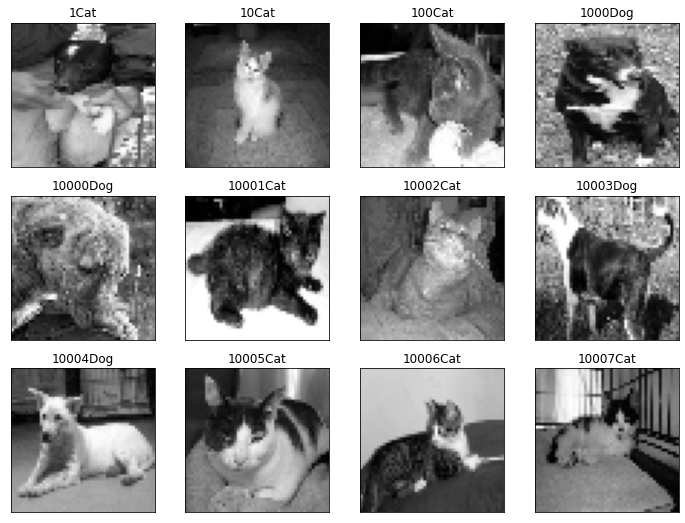

In [14]:
fig = plt.figure(figsize=(12, 9))

for num, data in enumerate(test_data[:12]): # yields pairs containing a count and a value yielded by the iterable argument.
    # cat: [1, 0]
    # dog: [0, 1]
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0] # Model has to be in memory
    # Model prediction for given input data.
    # Returns: array or `list` of array. The predicted probabilities.
    
    if np.argmax(model_out) == 1: str_label="Dog" # For dog [0, 1] 
    else: str_label="Cat"
        
    y.imshow(orig, cmap='gray') # Matplotlib has to be told to print the image in grayscale
    plt.title(img_num+str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()
    

In [15]:
with open('dog_percentage_test_data.csv', 'w') as f: # w-write
    f.write('id,label\n')
    # Writing this data in a csv file to generate a submission 

In [16]:
with open('dog_percentage_test_data.csv', 'a') as f: # a-append
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|███████████████████████████████████| 12500/12500 [00:28<00:00, 434.40it/s]


In [17]:
#tensorboard --logdir="foo:F:\New folder\files\Assignments\Semester 4\Miscellaneous\Anemoi Internship\Code\6 CNN\log"
#Command in terminal for tensorboard dashboard
#or use
#%tensorboard --logdir path/to/file

In [18]:
# Tutorial article link: https://pythonprogramming.net/convolutional-neural-network-kats-vs-dogs-machine-learning-tutorial/ 
# Video links: 
# https://www.youtube.com/watch?v=gT4F3HGYXf4 (Video part 1)
# https://www.youtube.com/watch?v=Ge65ukmJTzQ (Video part 2)
# https://youtu.be/ViO56ASqeks (Video part 3)
# https://www.youtube.com/watch?v=27FPv1VHSsQ (Video part 4)
# Kaggle dataset and info: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview
# Additional code: https://pythonprogramming.net/tflearn-machine-learning-tutorial/